<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-395/477 Redes Neuronales Artificiales I-2018 </h1>

<H3 align='center'> Tarea 1 - Redes Neuronales y *Deep Learning* </H3>
<hr style="height:2px;border:none"/>

**Temas**  
* Entrenamiento de redes *Feed-Forward* vı́a GD y variantes (SGD, mini-*batches*), *momentum*, regularización y tasa de aprendizaje adaptiva.
* Evaluación de redes *Feed-Forward* vı́a validación cruzada (cross-validation).
* Rol de capas ocultas y mayor profundidad (*Deep Learning*).
* Identificar el gradiente desvaneciente.
 

** Formalidades **  
* Equipos de trabajo de: 2 personas (*cada uno debe estar en condiciones de realizar una presentación y discutir sobre cada punto del trabajo realizado*)
* Se debe preparar una presentación de 20 minutos. Presentador será elegido aleatoriamente.
* Se debe preparar un (breve) Jupyter/IPython notebook que explique la actividad realizada y las conclusiones del trabajo
* Fecha de entrega y discusión: 26 de Octubre.
* Formato de entrega: envı́o de link Github al correo electrónico del ayudante (*<margarita.bugueno.13@sansano.usm.cl>*) , incluyendo al profesor en copia (*<cvalle@inf.utfsm.cl>*). Por favor especificar el siguiente asunto: [Tarea1-INF395-II-2018]

<hr style="height:2px;border:none"/>

#### Paquetes instalación

Para poder trabajar en el curso se necesitará instalar librerías para Python, por lo que se recomienda instalarlas a través de anaconda (para Windows y sistemas Unix) en un entorno virtual, donde podrán elegir su versión de Python. Se instalarán librerías como sklearn, una librería simple y de facil acceso para data science, keras en su versión con GPU (para cálculo acelerado a través de la tarjeta gráfica), además de que ésta utiliza como backend TensorFlow o Theano, por lo que habrá que instalar alguno de éstos, además de las librerías básicas de computer science como *numpy, matplotlib, pandas,* además de claramente *jupyter*.

* Descargar anacona
* Luego de instalar Anaconda y tenerla en el path de su computador crear un entorno virtual:
```
conda create -n redesneuronales python=version
```
con version, la version de Python que desea utilizar. Si está en Windows, se recomienda Python 3 debido a dependencias con una de las librerías a utilziar.

* Acceder al ambiente creado
```
source activate redesneuronales
```

* Instalar los paquetes a utilizar
```
conda install jupyter sklearn numpy pandas matplotlib keras-gpu tensorflow-gpu
```

*  Para salir del entorno
```
source deactivate redesneuronales
```

<hr style="height:2px;border:none"/>
La tarea se divide en secciones:

[1.](#primero) Predicción de Entalpía de Atomización  
[2.](#segundo) *Deep Networks*  
[3.](#tercero) Entendimiento de imágenes de personas

<a id="primero"></a>
## 1. Predicción de Entalpía de Atomización


Las simulaciones de propiedades moleculares son computacionalmente costosas y requieren de un arduo trabajo científico. El objetivo de esta sección corresponde a la utilización de métodos de aprendizaje automático supervisado (Redes Neuronales Artificiales) para predecir propiedades moleculares, en este caso la Energía de Atomización o Entalpía de Atomización, a partir de una base de datos de simulaciones obtenida mediante __[Quantum Espresso](http://www.quantum-espresso.org/)__. Si esto se lograse hacer con gran precisión, se abrirían muchas posibilidades en el diseño computacional y el descubrimiento de nuevas moléculas, compuestos y fármacos.

<img src="https://pubs.rsc.org/services/images/RSCpubs.ePlatform.Service.FreeContent.ImageService.svc/ImageService/Articleimage/2012/NR/c2nr11543c/c2nr11543c-f4.gif" title="Title text" width="40%"/>


La **entalpía de atomización** es la cantidad de variación de entalpía cuando los enlaces de un compuesto se rompen y los componentes se reducen a átomos individuales. Tal como se ha indicado, su tarea es la de predecir dicho nivel a partir de los atributos enunciados en el dataset puesto a vuestra disposición en *moodle*.

> a) Construya un *dataframe* con los datos a analizar y descríbalo brevemete. Además, realice la división de éste en los conjuntos de entrenamiento, validación y testeo correspondientes. Comente por qué se deben eliminar ciertas columnas.
```python
import pandas as pd
datos= pd.read_csv("EnergyMolecule/roboBohr.csv")
datos.shape
datos.info()
datos.describe()
...
datos.drop(columns=['Unnamed: 0','pubchem_id'],axis=1,inplace=True)
total=len(datos)
df_train=datos[:int(0.6*total)]                       #60% de los datos
df_val=datos[int(0.6*total):int(0.85*total)]          #25% de los datos
df_test=datos[int(0.85*total)::]                      #15% restante
```
>> a.1) Una buena práctica es la de normalizar los datos antes de trabajar con el modelo. **Explique por qué se aconseja dicho preprocesamiento**
>```python
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(df_train)
X_train_scaled = pd.DataFrame(scaler.transform(df_train),columns=df_train.columns)
X_val_scaled =  pd.DataFrame(scaler.transform(df_val),columns=df_val.columns)
X_test_scaled =  pd.DataFrame(scaler.transform(df_test),columns=df_test.columns)
...
y_train = df_train.pop('Eat').values.reshape(-1,1)
y_val = df_val.pop('Eat').values.reshape(-1,1)
...
X_train_scaled.drop(columns=['Eat'],axis=1,inplace=True)
X_val_scaled.drop(columns=['Eat'],axis=1,inplace=True)
X_test_scaled.drop(columns=['Eat'],axis=1,inplace=True)
```

 
>b) Muestre en un gráfico el error cuadrático (MSE) para el conjunto de entrenamiento y de pruebas vs número de *epochs* de entrenamiento, para una red *feedforward* de 3 capas, con 256 unidades ocultas y función de activación sigmoidal. Entrene la red usando gradiente descendente estocástico con tasa de aprendizaje (learning rate) 0.01 y 250 epochs de entrenamiento, en el conjunto de entrenamiento y de validación. Comente. Si observara divergencia durante el entrenamiento, determine si esto ocurre para cada repetición del experimento.
```python
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD
model = Sequential()
model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation="sigmoid"))
model.add(Dense(1, kernel_initializer='uniform',activation="linear")) 
model.compile(optimizer=SGD(lr=0.01),loss='mean_squared_error')
history = model.fit(X_train_scaled, y_train, epochs=250, verbose=1, validation_data=(X_val_scaled, y_val))
```
> c) Repita el paso anterior, utilizado ’**ReLU**’ como función de activación y compare con lo obtenido en b).  

> d) Repita b) y c) variando la tasa de aprendizaje (*learning rate*) en un rango sensible. Comente. Si observara divergencia durante el entrenamiento, determine si esto ocurre para cada repetición del experimento.
```python
import numpy as np
n_lr = 20
lear_rate = np.linspace(0,1,n_lr)
```

> e) Entrene los modelos considerados en b) y c) usando *progressive decay*. Compare y comente.
```python
n_decay = 10
lear_decay = np.logspace(-6,0,n_decay)
sgd = SGD(lr=0.2, decay=1e-6)
```

> f) Entrene los modelos considerados en b) y c) utilizando SGD en mini-*batches*. Experimente con diferentes tamaños del *batch*. Comente.
```python
n_batches = 21
batch_sizes = np.round(np.linspace(1,X_train_scaled.shape[0],n_batches))
model.fit(X_train_scaled,y_train,batch_size=50,epochs=250,validation_data=(X_val_scaled, y_val))
```
> g) Entrene los modelos obtenidos en b) y c) utilizando estrategias modernas para adaptar la tasa de aprendizaje. Compare los desempeños de adagrad, adadelta, RMSprop y adam. ¿Se observa en algún caso un mejor resultado final? ¿Se observa en algún caso una mayor velocidad de convergencia sobre el dataset de entrenamiento? ¿Sobre el dataset de validación?
```python
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta
moptimizer = Adagrad(lr=0.01)
model.compile(optimizer=moptimizer)
model.fit(X_train_scaled,y_train,batch_size=bs,epochs=250,validation_data=(X_val_scaled, y_val))
```

> h) Entrene los modelos obtenidos en b) y c) utilizando regularizadores $l_1$ y $l_2$ (*weight decay*). Compare los desempeños de prueba obtenidos antes y después de regularizar. Experimente con distintos valores del parámetro de regularización y comente. Además evalúe el efecto de regularizar solo la primera capa *vs* la segunda, comente.
```python
model = Sequential()
...#la regularization se debe incorporar a cada capa separadamente
idim=X_train_scaled.shape[1]
model.add(Dense(256,input_dim=idim,kernel_initializer='uniform',W_regularizer=l2(0.01)))
model.add(Activation('sigmoid'))
model.add(Dense(1, kernel_initializer='uniform',W_regularizer=l2(0.01)))
model.add(Activation('linear'))
```

> i) Entrene los modelos obtenidos en b) y c) utilizando *Dropout*. Compare los desempeños de prueba obtenidos antes y después de regularizar. Experimente con distintos valores del parámetro de regularización y comente.
```python
from keras.layers import Dropout
model = Sequential()
...
model.add(Dense(256,kernel_initializer='uniform'))
model.add(Activation('sigmoid'))
model.add(Dropout(0.2))
...
```

> j) Fijando todos los demás hiper-parámetros del modelo definido en b) y en c), utilice validación cruzada con un número de *folds* igual a *K* = 5 y *K*=10 para determinar el mejor valor correspondiente a un parámetro que usted elija (tasa de aprendizaje, número de neuronas, parámetro de regularización, etc) ¿El mejor parámetro para la red con sigmoidal es distinto que para ReLU? ¿Porqué sucede? Además mida el error real del modelo sobre el conjunto de pruebas, compare y concluya.
```python
from sklearn import cross_validation
Xm = X_train_scaled.values
ym = y_train
kfold = cross_validation.KFold(len(Xm), 10)
cvscores = []
for i, (train, val) in enumerate(kfold):
    ...# create model
    model = #model with hiperparam
    ...# Compile model
    model.compile(optimizer=,loss='mean_squared_error')
    ...# Fit the model
    model.fit(Xm[train], ym[train], epochs=250)
    ...# evaluate the model
    scores = model.evaluate(Xm[val], ym[val])
    cvscores.append(scores)
mse_cv = np.mean(cvscores)
```

In [3]:
import pandas as pd
datos= pd.read_csv("EnergyMolecule/roboBohr.csv")
datos.shape
datos.info()
datos.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16242 entries, 0 to 16241
Columns: 1278 entries, Unnamed: 0 to Eat
dtypes: float64(1276), int64(2)
memory usage: 158.4 MB


,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,1267,1268,1269,1270,1271,1272,1273,1274,pubchem_id,Eat
count,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,...,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000
mean,8139.041805,115.715266,22.445723,20.474191,18.529573,17.169350,15.816888,15.133152,14.471534,13.960759,...,0.000134,0.000133,0.003879,0.000131,0.000129,0.002155,0.000127,0.001201,33107.484300,-11.178969
std,4698.182820,113.198503,8.659586,7.670481,6.485777,5.512560,4.179691,3.885091,3.503075,3.357136,...,0.002728,0.002705,0.043869,0.002676,0.002633,0.032755,0.002594,0.024472,23456.785147,3.659133
min,0.000000,36.858105,2.906146,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-23.245373
25%,4068.250000,73.516695,17.969345,16.228071,15.165862,13.744092,13.653146,13.637784,12.759519,12.587359,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12298.250000,-13.475805
50%,8142.500000,73.516695,20.662511,18.631287,17.690729,16.020040,15.156646,13.848274,13.659233,13.652832,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,27731.500000,-10.835211
75%,12207.750000,73.516695,21.132432,20.739496,18.712895,18.297501,17.639688,16.154918,15.499474,14.900585,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,55020.750000,-8.623903
max,16272.000000,388.023441,73.563510,66.269180,66.268891,66.268756,66.268196,66.264158,66.258487,66.258177,...,0.062225,0.061999,0.500000,0.061534,0.059760,0.500000,0.057834,0.500000,74980.000000,-0.789513


In [4]:
#primera columna son los indices, la penultima es un public chemical id? no es necesario en este contexto
datos.drop(columns=['Unnamed: 0','pubchem_id'],axis=1,inplace=True)
total=len(datos)
df_train=datos[:int(0.6*total)]                       #60% de los datos
df_val=datos[int(0.6*total):int(0.85*total)]          #25% de los datos
df_test=datos[int(0.85*total)::]                      #15% restante

In [5]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(df_train)
X_train_scaled = pd.DataFrame(scaler.transform(df_train),columns=df_train.columns)
X_val_scaled =  pd.DataFrame(scaler.transform(df_val),columns=df_val.columns)

X_test_scaled =  pd.DataFrame(scaler.transform(df_test),columns=df_test.columns)
y_train = df_train.pop('Eat').values.reshape(-1,1)
y_val = df_val.pop('Eat').values.reshape(-1,1)

X_train_scaled.drop(columns=['Eat'],axis=1,inplace=True)
X_val_scaled.drop(columns=['Eat'],axis=1,inplace=True)
X_test_scaled.drop(columns=['Eat'],axis=1,inplace=True)

In [6]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD
model = Sequential()
model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation="sigmoid"))
model.add(Dense(1, kernel_initializer='uniform',activation="linear")) 
model.compile(optimizer=SGD(lr=0.01),loss='mean_squared_error')
history = model.fit(X_train_scaled, y_train, epochs=250, verbose=1, validation_data=(X_val_scaled, y_val))

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
9745/9745 [==============================] - 3s 286us/step - loss: 1.5044 - val_loss: 0.5708
Epoch 2/250
9745/9745 [==============================] - 2s 198us/step - loss: 0.6075 - val_loss: 0.4474
Epoch 3/250
9745/9745 [==============================] - 2s 186us/step - loss: 0.5255 - val_loss: 0.4506
Epoch 4/250
9745/9745 [==============================] - 2s 186us/step - loss: 0.4441 - val_loss: 0.3482
Epoch 5/250
9745/9745 [==============================] - 2s 197us/step - loss: 0.3841 - val_loss: 0.2987
Epoch 6/250
9745/9745 [==============================] - 2s 184us/step - loss: 0.3385 - val_loss: 0.3092
Epoch 7/250
9745/9745 [==============================] - 2s 195us/step - loss: 0.2965 - val_loss: 0.2494
Epoch 8/250
9745/9745 [==============================] - 2s 193us/step - loss: 0.2578 - val_loss: 0.2494
Epoch 9/250
9745/9745 [==============================] - 2s 193us/step - loss: 0.2306 - val_loss: 0.2139
Epoch 1

Epoch 78/250
9745/9745 [==============================] - 2s 172us/step - loss: 0.0306 - val_loss: 0.0526
Epoch 79/250
9745/9745 [==============================] - 2s 173us/step - loss: 0.0303 - val_loss: 0.0473
Epoch 80/250
9745/9745 [==============================] - 2s 176us/step - loss: 0.0294 - val_loss: 0.0501
Epoch 81/250
9745/9745 [==============================] - 2s 176us/step - loss: 0.0292 - val_loss: 0.0469
Epoch 82/250
9745/9745 [==============================] - 2s 180us/step - loss: 0.0290 - val_loss: 0.0434
Epoch 83/250
9745/9745 [==============================] - 2s 182us/step - loss: 0.0295 - val_loss: 0.0415
Epoch 84/250
9745/9745 [==============================] - 2s 162us/step - loss: 0.0284 - val_loss: 0.0434
Epoch 85/250
9745/9745 [==============================] - 2s 171us/step - loss: 0.0290 - val_loss: 0.0422
Epoch 86/250
9745/9745 [==============================] - 2s 166us/step - loss: 0.0303 - val_loss: 0.0428
Epoch 87/250
9745/9745 [======================

Epoch 155/250
9745/9745 [==============================] - 1s 143us/step - loss: 0.0198 - val_loss: 0.0385
Epoch 156/250
9745/9745 [==============================] - 2s 156us/step - loss: 0.0198 - val_loss: 0.0360
Epoch 157/250
9745/9745 [==============================] - 2s 158us/step - loss: 0.0195 - val_loss: 0.0375
Epoch 158/250
9745/9745 [==============================] - 2s 156us/step - loss: 0.0193 - val_loss: 0.0394
Epoch 159/250
9745/9745 [==============================] - 2s 155us/step - loss: 0.0196 - val_loss: 0.0353
Epoch 160/250
9745/9745 [==============================] - 2s 158us/step - loss: 0.0191 - val_loss: 0.0371
Epoch 161/250
9745/9745 [==============================] - 1s 140us/step - loss: 0.0193 - val_loss: 0.0382
Epoch 162/250
9745/9745 [==============================] - 1s 136us/step - loss: 0.0191 - val_loss: 0.0349
Epoch 163/250
9745/9745 [==============================] - 1s 144us/step - loss: 0.0191 - val_loss: 0.0348
Epoch 164/250
9745/9745 [============

9745/9745 [==============================] - 2s 160us/step - loss: 0.0147 - val_loss: 0.0335
Epoch 232/250
9745/9745 [==============================] - 1s 138us/step - loss: 0.0152 - val_loss: 0.0333
Epoch 233/250
9745/9745 [==============================] - 1s 143us/step - loss: 0.0150 - val_loss: 0.0337
Epoch 234/250
9745/9745 [==============================] - 1s 131us/step - loss: 0.0151 - val_loss: 0.0343
Epoch 235/250
9745/9745 [==============================] - 1s 108us/step - loss: 0.0151 - val_loss: 0.0322
Epoch 236/250
9745/9745 [==============================] - 1s 128us/step - loss: 0.0151 - val_loss: 0.0315
Epoch 237/250
9745/9745 [==============================] - 2s 173us/step - loss: 0.0151 - val_loss: 0.0393
Epoch 238/250
9745/9745 [==============================] - 2s 180us/step - loss: 0.0152 - val_loss: 0.0311
Epoch 239/250
9745/9745 [==============================] - 2s 203us/step - loss: 0.0155 - val_loss: 0.0349
Epoch 240/250
9745/9745 [==========================

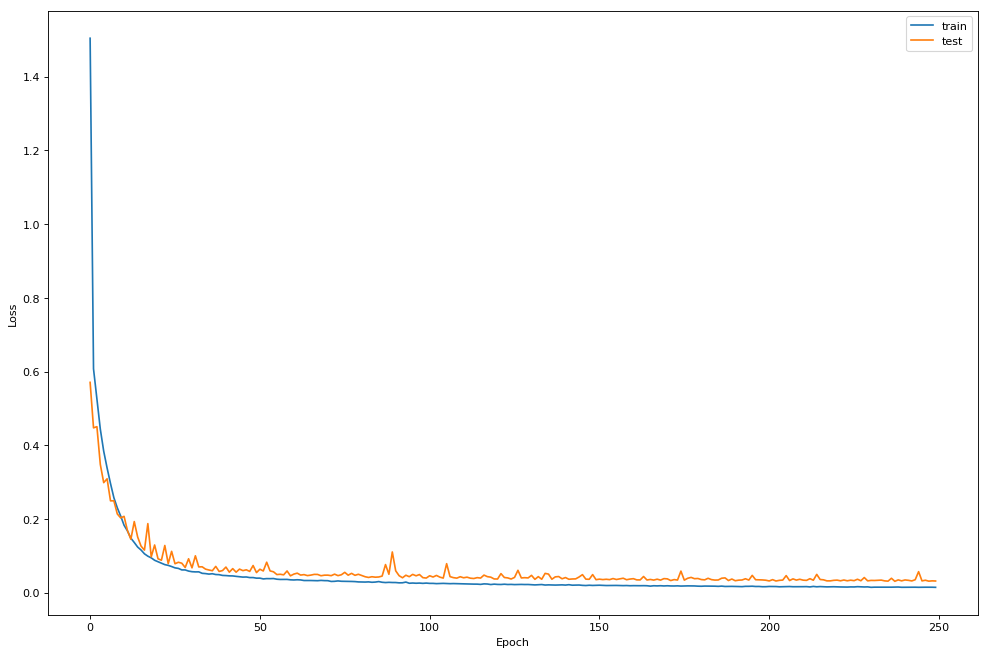

In [47]:
import matplotlib.pyplot as plt
plt.figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')
plt.plot(history.history['loss'],label='train');
plt.plot(history.history['val_loss'],label='test');
plt.ylabel('Loss');
plt.xlabel('Epoch')
plt.legend();
plt.show();

<a id="segundo"></a>
## 2. Deep Networks
Las *deep network*, o lo que hoy en día se conoce como *deep learning*, hace referencia a modelos de redes neuronales estructurados con muchas capas, es decir, el cómputo de la función final es la composición una gran cantidad de funciones ( $f^{(n)} = f^{(n-1)} \circ f^{(n-2)} \circ \cdots \circ f^{(2)} \circ f^{(1)} $ con $n \gg 0$ ).  
Este tipo de redes neuronales tienen una gran cantidad de parámetros, creciendo exponencialmente por capa con las redes *feed forward*, siendo bastante dificiles de entrenar comparadas con una red poco profunda, esto es debido a que requieren una gran cantidad de datos para ajustar correctamente todos esos parámetros. Pero entonces ¿Cuál es el beneficio que tienen este tipo de redes? ¿Qué ganancias trae el añadir capas a una arquitectura de una red neuronal?  

<img src="http://neuralnetworksanddeeplearning.com/images/tikz36.png" title="Title text" width="80%" height="20%" />



En esta sección se estudiará la complejidad de entrenar redes neuronales profundas, mediante la visualización de los gradientes de los pesos en cada capa, el cómo varía mientras se hace el *backpropagation* hacia las primeras capas de la red. 

> a) Se trabajará con las etiquetas escaladas uniformemente, es decir, $\mu=0$ y $\sigma=1$, ajuste sobre el conjunto de entrenamiento y transforme éstas además de las de validación y pruebas.
```python
scaler = StandardScaler().fit(df_train)
X_train_scaled = pd.DataFrame(scaler.transform(df_train),columns=df_train.columns)
y_train_scaled = X_train_scaled.pop('Eat').values.reshape(-1,1)
...#transform val and test
```

> b) Para el mismo problema definido anteriormente ([sección 1](#primero)) se entrenarán diferentes redes. En esta primera instancia se trabajará con la misma red de la pregunta b), inicializada con pesos uniforme. Visualice el gradiente de la función de pérdida (*loss*) para el conjunto de entrenamiento (promedio del gradiente de cada dato) respecto a los pesos en las distintas capas, para esto se le pedirá el cálculo del gradiente para una capa mediante la función de *gradients* (__[link](https://www.tensorflow.org/api_docs/python/tf/keras/backend/gradients)__) en el *backend* de Keras. Deberá generar un **histograma** para todos los pesos de cada capa antes y despues del entrenamiento con 250 *epochs*. Comente.
```python
model = Sequential()
model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation='sigmoid'))
model.add(Dense(1, kernel_initializer='uniform',activation='linear'))
sgd = SGD(lr=0.01)
model.compile(optimizer=sgd,loss='mean_squared_error')
- ###calculate gradients
from keras import backend as K
import tensorflow as tf
loss = keras.losses.mean_squared_error(model.output,y_train_scaled)
listOfVariableTensors = model.trainable_weights 
gradients = K.gradients(loss, listOfVariableTensors) #We can now calculate the gradients.
sess = K.get_session()
evaluated_gradients = sess.run(gradients,feed_dict={model.input:X_train_scaled.values})
evaluated_gradients = [gradient/len(y_train) for gradient in evaluated_gradients]
```

> c) Vuelva a generar los histogramas para los gradientes de los pesos de cada capa antes y después del entrenamiento pero ahora entrenando una red mucho más profunda de 6 capas, 5 capas escondidas y 1 de salida. Utilice el inicializador de pesos *uniform* el cual inicializa mediante una distribución uniforme entre $-1/\sqrt{N}$ y $1/\sqrt{N}$ para cada capa, con $N$ el número de neuronas de la capa anterior. Por simplicidad visualice las 3-4 primeras capas de la red. Comente si observa el efecto del *gradiente desvaneciente* antes y/o después de entrenar.
```python
model = Sequential()
model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation='sigmoid'))
model.add(Dense(256, kernel_initializer='uniform',activation='sigmoid'))
model.add(Dense(256,  kernel_initializer='uniform',activation='sigmoid'))
model.add(Dense(256, kernel_initializer='uniform',activation='sigmoid'))
model.add(Dense(256, kernel_initializer='uniform',activation='sigmoid'))
model.add(Dense(1, kernel_initializer='uniform',activation='linear'))
sgd = SGD(lr=0.01)
model.compile(optimizer=sgd,loss='mean_squared_error')
```

> d) Vuelva a generar los histogramas para los gradientes de los pesos de cada capa antes y después del entrenamiento, pero ahora entrenando la red profunda con el inicializador de Glorot [[1]](#refs), es decir, una distribución uniforme entre -$\sqrt{6/(N_{in}+N_{out})}$  y $\sqrt{6/(N_{in}+N_{out})}$ . Por simplicidad visualice las 3-4 primeras capas de la red. Comente si el efecto del *gradiente desvaneciente* se amortigua antes y/o después de entrenar.
```python
model = Sequential()
model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='glorot_uniform',activation='sigmoid'))
model.add(Dense(256, kernel_initializer='glorot_uniform',activation='sigmoid'))
model.add(Dense(256,  kernel_initializer='glorot_uniform',activation='sigmoid'))
model.add(Dense(256, kernel_initializer='glorot_uniform',activation='sigmoid'))
model.add(Dense(256, kernel_initializer='glorot_uniform',activation='sigmoid'))
model.add(Dense(1, kernel_initializer='glorot_uniform',activation='linear'))
sgd = SGD(lr=0.01)
model.compile(optimizer=sgd,loss='mean_squared_error')
```

> e) Vuelva a repetir la experimentación ahora cambiando la función de activación por ReLU, es decir, deberá visualizar los gradientes de los pesos de cada capa antes y después del entrenamiento, con inicialización *uniform* y comparar con la inicialización de He [[2]](#refs), es decir, una distribución uniforme entre -$\sqrt{6/N_{in}}$ y $\sqrt{6/N_{in}} $. Comente si ocurre el mismo fenómeno anterior (para función sigmoidal) sobre el efecto del *gradiente desvaneciente* para la función ReLU. Explique la importancia de la inicialización de los pesos dependiendo de la arquitectura.
```python
...
model.add(Dense(nh, kernel_initializer='uniform',activation='relu')) #uniform
...
or
...
model.add(Dense(nh, kernel_initializer='he_uniform',activation='relu')) #he
...
```
> f) ¿Qué es lo que sucede con la red más profunda? ¿El modelo logra convergencia en su entrenamiento? Modifique aspectos estructurales (funciones de activación, inicializadores, regularización, *momentum*, variación de tasa de aprendizaje, entre otros) de la red profunda de 6 capas definida anteriormente (no modifique la profundidad ni el número de neuronas) para lograr un error cuadrático medio (*mse*) similar o menor al de una red no profunda, como la definida en b) en esta sección, sobre el conjunto de pruebas.

> g) Experimente con la utilización de una función activación auxiliar (debido a que aproxima) a '**ReLU**' y que es continua derivable (**softplus**) ¿Cuál es el beneficio de ésta con respecto ReLU? Comente.
```python
...
model.add(Dense(nh, kernel_initializer='he_uniform',activation='softplus')) #softplus
...
```

> h) Pruebe con utilizar una red *shallow* (poco profunda), es decir, sitúe todas las neuronas en una única capa ¿Qué sucede con la convergencia del algoritmo? ¿Por qué sucede este fenómeno?
```python
model = Sequential()
model.add(Dense(1024, input_dim=X_train_scaled.shape[1], kernel_initializer='choose',activation='sigmoid'))
model.add(Dense(1, kernel_initializer='choose',activation='linear'))
model.compile(optimizer=sgd,loss='mean_squared_error')
model.fit(X_train_scaled.values, y_train_scaled, epochs=250, verbose=1, validation_data=(X_val_scaled.values, y_val_scaled))
```


<a id="tercero"></a>
## 3. Entendimiento de imágenes de personas

El problema de inferir ciertas características de una persona a través de una foto de ella puede resultar bastante dificil incluso para nosotros, como por ejemplo de qué país es, la emoción que expresa, la edad que tiene, o el género. La automatización de este proceso para que máquinas logren identificar ciertas características de una persona puede ser algo crucial para el futuro desarrollo de Inteligencia Artificial.


<img src="https://i.imgur.com/6B072GE.jpg" width="60%" height="20%" />


En esta actividad trabajaremos con unos datos (imágenes) con la tarea de predecir la **edad** (*target value*) de la persona en la imagen. Los datos con corresponden a 3640 imágenes de Flickr de rostros de personas, pero, debido a que trabajamos con redes *feed forward*, se trabajará con representaciones de características extraídas. Para ésto necesitará descargar los datos del siguiente __[link](http://chenlab.ece.cornell.edu/people/Andy/ImagesOfGroups.html)__ en el extracto de *ageGenderClassification* o a través de la consola Unix.
```
wget http://chenlab.ece.cornell.edu/projects/ImagesOfGroups/ageGenderClassification.zip
```

Se trabajará con archivos *.mat* que pueden ser cargados de la siguiente manera:
```python
import scipy.io as sio
sio.loadmat("file.mat")
```

Para descripción sobre las columnas están en el archivo readme a través del siguiente __[link](http://chenlab.ece.cornell.edu/projects/ImagesOfGroups/README.txt)__ o a través de la consola Unix:
```
wget http://chenlab.ece.cornell.edu/projects/ImagesOfGroups/README.txt
```


> a) Cargue los datos dos dataset de entrenamiento y de pruebas ¿Cuántos datos hay en cada conjunto?
```python
import scipy.io as sio
mat_train = sio.loadmat("./eventrain.mat")
mat_test = sio.loadmat("./eventest.mat")
data_train= mat_train["trcoll"][0][0]
data_test= mat_test["tecoll"][0][0]
```

> b) Eliga cuál representación utilizará para trabajar los datos y entregárselos como *input* al modelo neuronal denso. Además extraiga las etiquetas del problema. Describa los datos utilziados.
```python
genFeat = data[0]  #it can be used as representation: contextual features
ageClass = data[1] #target
ffcoefs = data[3]   #it can be used as representation: fisherface space
faceGist = data[4]  #it can be used as representation
```

> c) Defina y entrene una modelo de red neuronal *feed forward* para la inferencia de la edad de la persona a través de la representación escogida. Intente llegar a un *mse* menor a 100 en el conjunto de pruebas. Recuerde que **NO** puede seleccionar modelos a través del conjunto de pruebas. Visualice sus resultados si estima conveniente.


*Nota: Puede notar que la cantidad de edades presentes en el problema son pocas (1,  5, 10, 16, 28, 51 o 75 años), por lo que puede tratar al problema así como de regresión o clasificación (considerando cada edad como una clase)*


#### Ayuda:
> Para problemas de clasificación de múltiples clases es necesario transformar las etiquetas categóricas en *one hot vector*, donde cada columna del vector representará una categoría. Por ejemplo, si existen tres categorías (perro, gato, ratón), la categoría perro puede ser codificada como [1,0,0], y la categoría ratón puede ser codificada como [0,0,1]. Para ésto la librería *keras* nos ayuda:

```python
import keras
y_onehot = keras.utils.to_categorical(y_train,num_classes=edades_distintas)
```

<a id="refs"></a>
## Referencias
[1] Glorot, X., & Bengio, Y. (2010, March). *Understanding the difficulty of training deep feedforward neural networks*. In Proceedings of the thirteenth international conference on artificial intelligence and statistics (pp. 249-256).    
[2]  He, K., Zhang, X., Ren, S., & Sun, J. (2015). *Delving deep into rectifiers: Surpassing human-level performance on imagenet classification*. In Proceedings of the IEEE international conference on computer vision (pp. 1026-1034).  
[3] Gallagher, A. C., & Chen, T. (2009, June). *Understanding images of groups of people*. In Computer Vision and Pattern Recognition, 2009. CVPR 2009. IEEE Conference on (pp. 256-263). IEEE.